# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [2]:
!pip -q install ./python

The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [3]:
from unityagents import UnityEnvironment
import numpy as np
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from datetime import datetime, timedelta

from ddpg_agent import Agent


env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [6]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: 0.04500000085681677


In [7]:
# Examine the agents
agents = Agent(state_size = state_size, 
               action_size = action_size,
               num_agents = num_agents, 
               random_seed = 0)
print(agents.actor_local)
print(agents.critic_local)

Actor(
  (fc1): Linear(in_features=24, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=2, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Critic(
  (fcs1): Linear(in_features=24, out_features=256, bias=True)
  (fc2): Linear(in_features=258, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [8]:
# ddpg_train function

def ddpg_train(n_episodes = 5000, max_t = 1000):
    
    # lists to store final results
    scores_deque = deque(maxlen = 100)
    scores = []
    avg_score_list = []
    print_every = 100
    target_score = 0.5
    
    # train loop
    for i_episode in range(1, n_episodes + 1):
        
        # resetting the environment
        env_info = env.reset(train_mode = True)[brain_name]
        
        # get the current state for each agent
        state = env_info.vector_observations
        
        # reset 
        agents.reset()
        
        # initialize scores for each agent
        score = np.zeros(num_agents)
        
        # for current episode till max timesteps
        for t in range(max_t):
            action = agents.act(state) 
            env_info = env.step(action)[brain_name] 
            next_state = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            agents.step(state, action, rewards, next_state, dones)
            state = next_state
            score += rewards
            
            if np.any(dones):
                break 
        
        # avergae scores for this episode
        scores_deque.append(np.mean(score))
        scores.append(np.mean(score))
        
        # average scores for all episodes
        avg_score = np.mean(scores_deque)
        avg_score_list.append(avg_score)
        
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.3f}'.\
              format(i_episode, avg_score, np.mean(score)), end="")
        
        if (i_episode % print_every) == 0 or (avg_score > target_score):
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, avg_score))
            
            torch.save(agents.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agents.critic_local.state_dict(), 'checkpoint_critic.pth') 
            
            if avg_score > target_score:
                print('\nEnvironment solved in {:d} episodes!'.format(i_episode))
                break
        
    return scores, avg_score_list

Episode 100	Average Score: 0.00	Score: -0.005
Episode 200	Average Score: 0.02	Score: -0.0055
Episode 300	Average Score: -0.00	Score: -0.005
Episode 400	Average Score: -0.00	Score: -0.005
Episode 500	Average Score: -0.00	Score: -0.005
Episode 600	Average Score: -0.00	Score: -0.005
Episode 700	Average Score: -0.00	Score: -0.005
Episode 800	Average Score: 0.02	Score: 0.04555
Episode 900	Average Score: 0.05	Score: 0.0455
Episode 1000	Average Score: 0.09	Score: 0.045
Episode 1100	Average Score: 0.10	Score: 0.2455
Episode 1200	Average Score: 0.13	Score: 0.0455
Episode 1300	Average Score: 0.33	Score: 0.0455
Episode 1370	Average Score: 0.51	Score: 1.0955

Environment solved in 1370 episodes!


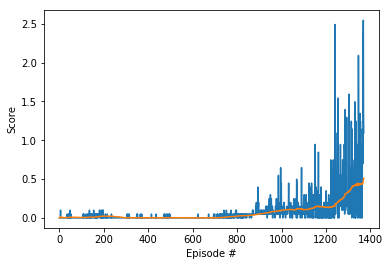

In [9]:
# run the ddpg algorithm
scores, avg_score_list = ddpg_train()

# plot results
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores) + 1), scores)
plt.plot(np.arange(1, len(avg_score_list) + 1), avg_score_list)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
env.close()

In [1]:
# download everything for submission
!tar cvfz notebook.tar.gz *

Tennis.ipynb
__pycache__/
__pycache__/ddpg_agent.cpython-36.pyc
__pycache__/model.cpython-36.pyc
checkpoint_actor.pth
checkpoint_critic.pth
ddpg_agent.py
model.py
python/
python/trainer_config.yaml
python/README.md
python/communicator_objects/
python/communicator_objects/unity_message_pb2.py
python/communicator_objects/unity_input_pb2.py
python/communicator_objects/unity_to_external_pb2.py
python/communicator_objects/header_pb2.py
python/communicator_objects/unity_rl_input_pb2.py
python/communicator_objects/unity_rl_initialization_input_pb2.py
python/communicator_objects/unity_to_external_pb2_grpc.py
python/communicator_objects/brain_parameters_proto_pb2.py
python/communicator_objects/space_type_proto_pb2.py
python/communicator_objects/agent_info_proto_pb2.py
python/communicator_objects/resolution_proto_pb2.py
python/communicator_objects/agent_action_proto_pb2.py
python/communicator_objects/__init__.py
python/communicator_objects/engine_configuration_proto_pb2.py
python/communicator_ob